### Машинное обучение
## Домашнее задание №3 - Градиентный бустинг

**Общая информация**

**Срок сдачи:** 5 декабря 2023, 23:59   
**Штраф за опоздание:** -2 балла за каждые сутки

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [66]:
import numpy as np

from scipy import stats
from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import random
import matplotlib.pyplot as plt

In [7]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', 
                 learning_rate=0.1, 
                 n_estimators=50, 
                 colsample=1.0, 
                 subsample=1.0, 
                 *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.losses_dict = {
            'mse' : self.mse_grad,
            'exploss' : self.exp_grad,
            'logloss' : self.logloss_grad
        }

    def mse_grad(self, y_true, y_pred):
      return 2 * (y_true - y_pred)

    def exp_grad(self, y_true, y_pred):
      return np.exp(y_true * -y_pred) * y_true
      
   
    def logloss_grad(self, y_true, y_pred):
      d1 = np.exp(-y_pred * y_true) 
      return (d1 * y_true) / (1 + d1)


    def fit(self, X, y, base_model = DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
          
        loss_func = self.losses_dict[self.loss]
        obj_sample_size = int(np.round(self.subsample * X.shape[0]))
        cols_sample_size = int(np.round(self.colsample * X.shape[1]))

        self.models = []
        self.features = []

        if init_model is None:
          y_pred = 0
          self.startModel = None
        else:
          self.startModel = init_model()
          self.startModel.fit(X, y)
          y_pred = self.startModel.predict(X)

        for _ in range(self.n_estimators):
          estimator = base_model(*self.args, **self.kwargs)
          grad = loss_func(y, y_pred)
          x_train_size = np.array(random.sample(range(X.shape[0]), obj_sample_size))
          cols = np.array(random.sample(range(X.shape[1]), cols_sample_size))
          estimator.fit(X[x_train_size[:, np.newaxis], cols], grad[x_train_size])
          y_pred += self.learning_rate * estimator.predict(X[:, cols])
          self.models.append(estimator)
          self.features.append(cols)
        


        
    def predict(self, X):
      if self.startModel is None:
        y_pred = 0
      else:
        y_pred = self.startModel.predict(X)
      for model, feature in zip(self.models, self.features):
        y_pred += self.learning_rate * model.predict(X[:, feature])

      if self.loss == 'mse':       
            return np.around(y_pred).astype(int)
      else:
            return np.where(y_pred>=0, 1, -1)

In [11]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [12]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [13]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [15]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [16]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [44]:
n_estimators_range = [i for i in range(5, 200, 10)] 
loss_plot = {
    'mse' : [],
    'exploss' : [],
    'logloss' : []}

In [45]:
from tqdm import tqdm
for loss_type in tqdm(loss_plot.keys()):
    for n_estimators in tqdm(n_estimators_range, desc=f"{loss_type}"):
        my_clf = MyGradientBoostingClassifier(
            loss=loss_type,
            n_estimators=n_estimators,
            colsample=1.0,
            subsample=1.0,
            random_state=0
        )
        my_clf.fit(X_train, y_train)
        pred = np.around(my_clf.predict(X_test)).astype(int)
        score = accuracy_score(y_pred=pred, y_true=y_test)
        loss_plot[loss_type].append(score)

100%|██████████| 3/3 [16:42<00:00, 334.08s/it]


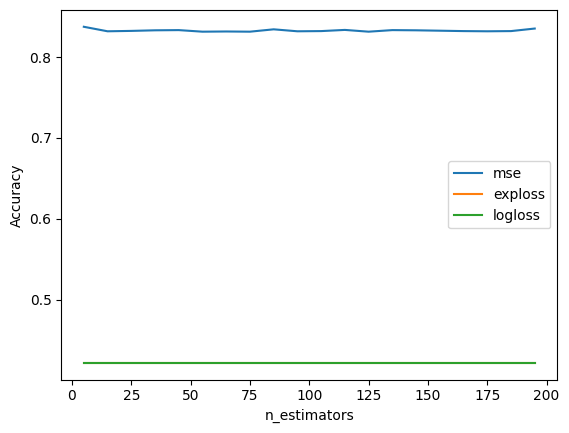

In [46]:
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
for loss_type in loss_plot.keys():
    plt.plot(n_estimators_range, loss_plot[loss_type], label=loss_type)
plt.legend()
plt.show()

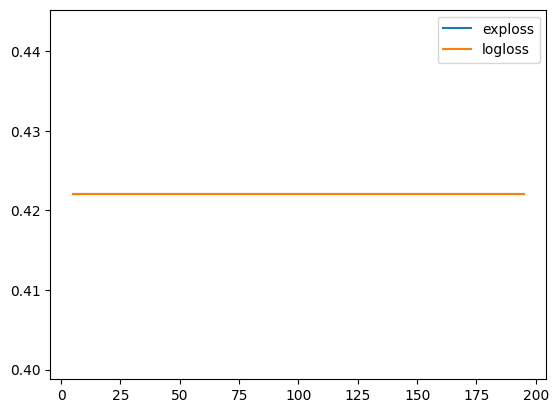

In [47]:
for loss_type in list(loss_plot.keys())[1:]:
    plt.plot(n_estimators_range, loss_plot[loss_type], label=loss_type)
    
plt.legend()
plt.show()

Мы видим, что лучшим критерием ошибки при стандартных параметрах является MSE, а для обучения достаточно уже 5 итераций, но возьмем для стабильности 15, вдруг будут изменения при настройке параметров.
Подберем colsample и subsample.

In [48]:
class GridSearch:

  def __init__(self, losses, cols_sample, sub_samples):
    self.n_estimators =  15
    self.losses = losses
    self.cols_sample = cols_sample
    self.sub_samples = sub_samples
    self.max_accuracy = -1
  def findParams(self, X_train, y_train, X_test, y_test):
    logger = {'loss' : 'mse',
              'colsample' : 0,
              'subsample' :0,
              'n_estimators' : self.n_estimators}

    for loss in self.losses:
      for cols_s in self.cols_sample:
        for sub_s in self.sub_samples:
          my_clf = MyGradientBoostingClassifier(n_estimators=self.n_estimators, 
                                                loss = loss, colsample = cols_s,
                                                subsample = sub_s)
          if loss == 'mse':
            my_clf.fit(X_train, y_train)
            accuracy_pred = accuracy_score(my_clf.predict(X_test), y_test)
          else:
            my_clf.fit(X_train, 2 * y_train -1 ) # для logloss и exploss превращаем 0 класс в -1
            accuracy_pred = accuracy_score(my_clf.predict(X_test), 2 * y_test -1)

          if accuracy_pred > self.max_accuracy:
            logger['loss'] = loss
            logger['colsample'] = cols_s
            logger['subsample'] = sub_s
            self.max_accuracy =  accuracy_pred
    return logger, self.max_accuracy

In [53]:
grid_search = GridSearch(losses = ['mse'],
                 cols_sample = np.linspace(0.2, 1, 5),
                 sub_samples = np.linspace(0.2, 1, 5))

In [54]:
best_params, accuracy = grid_search.findParams(X_train, y_train, X_test ,y_test)

In [62]:
best_params

{'loss': 'mse', 'colsample': 0.8, 'subsample': 0.8, 'n_estimators': 15}

In [63]:
accuracy

0.8892926356589147


Оптимальные параметры mse, n_estimators=15, colsample=0.8, subsample=0.8

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [58]:
from sklearn.ensemble import RandomForestRegressor

In [60]:
my_clf = MyGradientBoostingClassifier(loss='mse', 
                                      learning_rate=1e-1, 
                                      n_estimators=15, 
                                      colsample=0.8, 
                                      subsample=0.8,
                                      random_state=0)

my_clf.fit(X_train, y_train, init_model=RandomForestRegressor)

pred = np.around(my_clf.predict(X_test)).astype(int)
score = accuracy_score(y_pred=np.round(my_clf.predict(X_test)).astype(int), y_true=y_test)
print(f"accuracy: {np.round(score, 3)}")

accuracy: 0.878


Просто случайный лес не смог улучшить результат, возможно это из-за того, что всё таки случайный лус уже не слишком слабый алгоритм и его хорошее начальное приближение, мешает ему в дальнейшем обучении

In [79]:
n_boostings = 10

pred = []
bootstrap_size = X.shape[0]
bagging_ensemble = []

for i in tqdm(range(n_boostings)):
    bootstrap_idx = np.random.choice(range(X_train.shape[0]), replace=True, size=bootstrap_size)
    X_bootstrap, y_bootstrap = X_train[bootstrap_idx], y_train[bootstrap_idx]
    
    my_clf = MyGradientBoostingClassifier(loss='mse', 
                                      learning_rate=1e-1, 
                                      n_estimators=15, 
                                      colsample=0.8, 
                                      subsample=0.8,
                                      random_state=0)

    my_clf.fit(X_bootstrap, y_bootstrap)
    bagging_ensemble.append(my_clf)
    pred.append(my_clf.predict(X_test))

100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


In [80]:
pred = np.array(pred)

pred_mean = np.mean(pred, axis=0)
pred_mode = stats.mode(np.round(pred).astype(int), keepdims=False)[0]
pred_median = np.median(np.round(pred).astype(int), axis=0)

score_mean = accuracy_score(y_pred=np.round(pred_mean).astype(int), y_true=y_test)
score_mode = accuracy_score(y_pred=np.round(pred_mode).astype(int), y_true=y_test)
score_median = accuracy_score(y_pred=np.round(pred_median).astype(int), y_true=y_test)

print(f"Accuracy| mean: {np.round(score_mean, 5)} mode: {np.round(score_mode, 5)} median: {np.round(score_median, 5)}")

Accuracy| mean: 0.88178 mode: 0.88178 median: 0.88178


Бэгинг тоже не смог улучшить результат, хотя и подобрался к нему чуть ближе. У бэггинга за счет комбинации моделей ошибка снижается, поэтому если возможно поиграться с параметрами получится еще увеличить качество.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [81]:
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

In [82]:
base_models = [SVR, LinearRegression, RandomForestRegressor, ElasticNet]

In [85]:
for model in base_models:
    my_clf = MyGradientBoostingClassifier(loss='mse', 
                                      learning_rate=1e-1, 
                                      n_estimators=15, 
                                      colsample=0.8, 
                                      subsample=0.8,
                                  random_state=0)
    my_clf.fit(X_train, y_train, init_model=model)
    print(f"{model.__name__} : {accuracy_score(my_clf.predict(X_test), y_test)}")

SVR : 0.8788759689922481
LinearRegression : 0.8837209302325582
RandomForestRegressor : 0.8810562015503876
ElasticNet : 0.8638565891472868


Как мы видим все модели справились довольно неплохо, хоть и не перебили результат лучшего стандартного решения с подбором параметров. 
Как мы знаем линейные модели, конечно, не луччший выбор для бустинга, так как комбинация линейных моделей даёт линейную модель, но так как классификация была бинарная результат оказался не плохой. Лучше всех из линейных моделей оказало

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

